In [2]:
import os
import common

# Assign notebook and folder names
notebook_name = '02_robust_pca'
figure_folder = os.path.join(common.FIGURE_FOLDER, notebook_name)
data_folder = os.path.join(common.DATA_FOLDER, notebook_name)

# Make the folders
! mkdir -p $figure_folder
! mkdir -p $data_folder

In [3]:
%pdb

Automatic pdb calling has been turned ON


In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [5]:
input_folder = os.path.join(common.DATA_FOLDER, '001_downsample_macosko_data')

csv = os.path.join(input_folder, 'expression_table1_subset.csv')

table1 = pd.read_csv(csv, index_col=0)
print(table1.shape)
table1.head()

(300, 259)


,RHO,GNAT1,SLC24A1,PDE6B,PDC,CNGA1,RP1,SAG,NR2E3,NRL,...,SLC6A6,MAP1B,TMA7,STX3,SYT1,CRX,SNAP25,MPP4,NEUROD1,A930011O12RIK
barcode,,,,,,,,,,,,,,,,,,,,,
r1_TTCCTGCTAGGC,14,3,1,3,12,0,1,7,2,2,...,1,1,2,0,0,0,0,1,0,0
r1_TGGAGATACTCT,23,8,6,4,13,9,2,19,1,1,...,3,0,2,1,0,1,0,2,0,1
r1_CGTCTACATCCG,14,4,7,1,6,3,0,13,2,2,...,0,1,0,3,0,1,0,2,0,0
r1_CAAGCTTGGCGC,62,18,10,20,29,2,8,31,9,2,...,0,5,7,3,2,6,2,3,7,11
r1_ACTCACATAGAG,10,1,0,1,5,2,1,7,3,1,...,1,1,2,3,1,2,1,0,3,0


## Assign colors basd on clusters

In [6]:
cluster_identities = pd.read_table('macosko2015/retina_clusteridentities.txt', header=None,
                                   names=['barcode', 'cluster_id'], index_col=0, squeeze=True)
print(cluster_identities.shape)
cluster_identities.head()

(44808,)


barcode
r1_GGCCGCAGTCCG     2
r1_CTTGTGCGGGAA     2
r1_GCGCAACTGCTC     2
r1_GATTGGGAGGCA     2
r1_GTGCCGCCTCTC    25
Name: cluster_id, dtype: int64

In [7]:
cluster_identities_table1 = cluster_identities.loc[table1.index]
cluster_identities_table1.head()

barcode
r1_TTCCTGCTAGGC    24
r1_TGGAGATACTCT    24
r1_CGTCTACATCCG    24
r1_CAAGCTTGGCGC    24
r1_ACTCACATAGAG    24
Name: cluster_id, dtype: int64

In [8]:
cluster_ids = cluster_identities_table1.unique()
colors = sns.color_palette(palette='Set2', n_colors=len(cluster_ids))
id_to_color = dict(zip(cluster_ids, colors))

color_labels = [id_to_color[i] for i in cluster_identities_table1]
color_labels[:4]

[(0.40000000000000002, 0.76078431372549016, 0.6470588235294118),
 (0.40000000000000002, 0.76078431372549016, 0.6470588235294118),
 (0.40000000000000002, 0.76078431372549016, 0.6470588235294118),
 (0.40000000000000002, 0.76078431372549016, 0.6470588235294118)]

## Plot the original, dropout'd data

In [9]:
sns.set(style='whitegrid')

[<matplotlib.text.Text at 0x11a9df860>, <matplotlib.text.Text at 0x11a9cb5c0>]

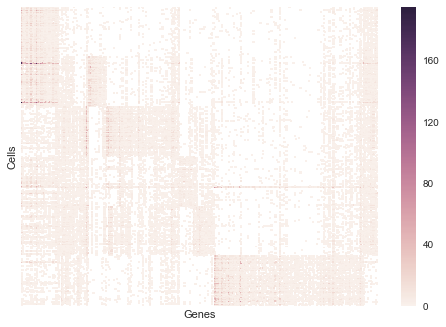

In [10]:
mask = table1 == 0

fig, ax = plt.subplots()
sns.heatmap(table1, mask=mask, xticklabels=[], yticklabels=[])
ax.set(xlabel='Genes', ylabel='Cells')

### Maybe this is small enough for a clustered heatmap

/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


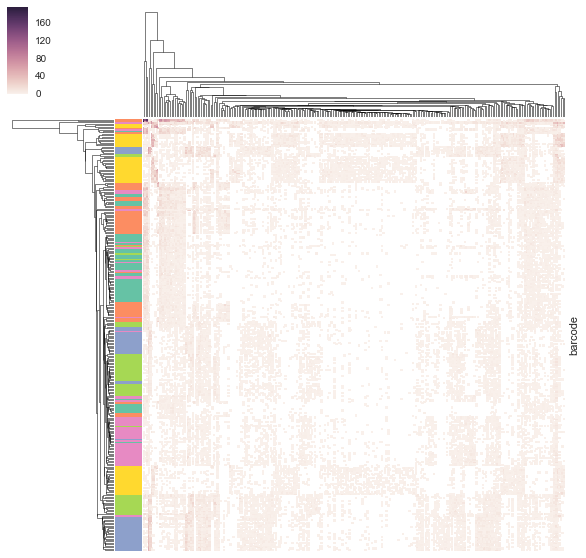

In [11]:
clustergrid = sns.clustermap(table1, mask=mask, xticklabels=[], yticklabels=[], 
                             row_colors=color_labels)

## Add Robust PCA implementations to path

In [12]:
import sys

sys.path.extend(['/Users/olgabot/code/robust-pca/', '/Users/olgabot/code/rpcaADMM/'])

import r_pca
import rpcaADMM

In [104]:
r_pca.R_pca??

In [13]:
%%time
rpca_alm = r_pca.R_pca(table1.as_matrix())
rpca_alm.fit()

iteration: 1, error: 56422.70929985199
iteration: 100, error: 0.6880109089868683
iteration: 200, error: 0.14702804887281945
iteration: 251, error: 0.08979496489742976
CPU times: user 15.1 s, sys: 145 ms, total: 15.3 s
Wall time: 3.9 s


In [14]:
rpca_alm.lmbda

0.057735026918962568

In [15]:
U, s, V = np.linalg.svd(rpca_alm.L)

In [16]:
U

array([[-0.04272573, -0.02831748, -0.00597595, ...,  0.00333803,
         0.00177218,  0.01580328],
       [-0.07864946, -0.04817703, -0.01001383, ..., -0.0114292 ,
         0.00301747,  0.00501156],
       [-0.05291033, -0.03174095, -0.00638981, ..., -0.00100707,
        -0.00933078,  0.01188982],
       ..., 
       [-0.01026694,  0.02322763, -0.03528178, ...,  0.03940001,
         0.00723089, -0.05019267],
       [-0.04240066,  0.0962479 , -0.13841497, ..., -0.00552324,
         0.00943978, -0.00371454],
       [-0.00583065,  0.02502047, -0.03610277, ..., -0.0189998 ,
        -0.03432167,  0.05701413]])

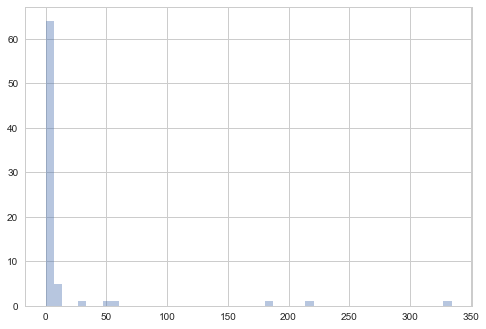

In [17]:
sns.distplot(s[s > 0.1], kde=False)

In [59]:
diff = rpca_alm.L - table1

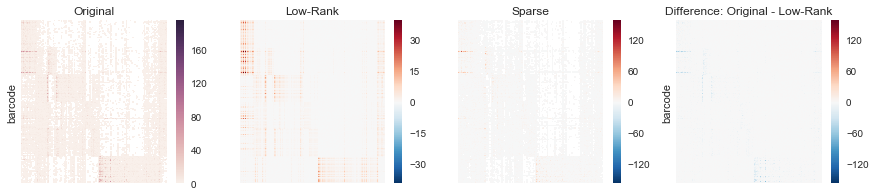

In [60]:
datasets = {'Original': table1, 'Low-Rank':rpca_alm.L, 'Sparse': rpca_alm.S, 
            'Difference: Original - Low-Rank': diff}

common.heatmaps(datasets)

In [61]:
L = pd.DataFrame(rpca_alm.L, index=table1.index, columns=table1.columns)
L.head()

,RHO,GNAT1,SLC24A1,PDE6B,PDC,CNGA1,RP1,SAG,NR2E3,NRL,...,SLC6A6,MAP1B,TMA7,STX3,SYT1,CRX,SNAP25,MPP4,NEUROD1,A930011O12RIK
barcode,,,,,,,,,,,,,,,,,,,,,
r1_TTCCTGCTAGGC,7.272295,3.048168,1.562439,2.198954,4.326513,1.385031,1.989380,6.541110,1.689744,1.345555,...,0.313114,0.767164,0.864139,0.388544,0.150222,0.752207,0.272070,0.832861,1.258661,0.856469
r1_TGGAGATACTCT,13.174154,5.480442,2.635686,3.713715,7.521109,2.310180,3.257731,11.804131,2.741139,2.363235,...,0.815807,1.031292,1.597556,0.999699,0.884529,1.033574,0.724387,1.236772,2.351665,1.286273
r1_CGTCTACATCCG,8.820288,3.785870,1.735920,2.396476,5.171789,1.561243,2.092837,7.836292,1.876383,1.537487,...,0.382253,0.972003,0.828423,0.656586,0.391978,0.916053,0.429003,0.958758,1.373776,0.703660
r1_CAAGCTTGGCGC,25.982230,11.021147,5.608453,7.951609,15.774301,4.953723,7.427482,24.229816,6.077871,4.769225,...,1.644721,3.139924,3.271503,2.906614,1.999058,2.751189,2.020806,3.190714,5.678790,3.812966
r1_ACTCACATAGAG,7.614892,3.096781,1.282597,1.838656,4.131712,1.165996,1.602792,6.662531,1.363853,1.237918,...,0.687691,0.804546,1.079846,0.874430,0.684653,0.541885,0.754388,0.499074,1.349995,0.391946


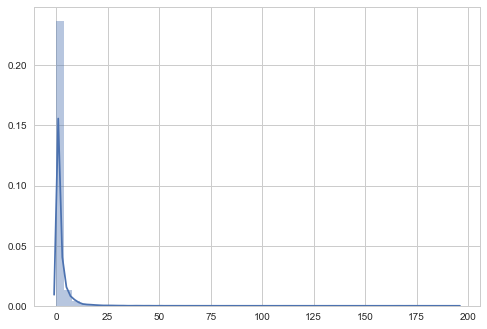

In [63]:
sns.distplot(table1.values.flat)

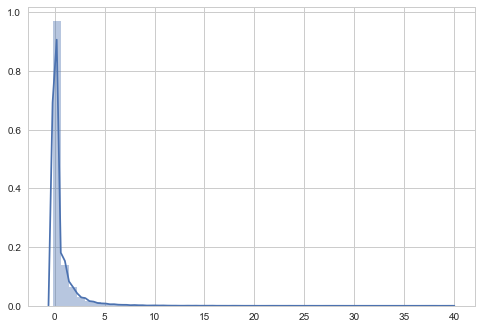

In [62]:
sns.distplot(L.values.flat)

In [101]:
diff = table1 - L
diff_tidy = diff.unstack().reset_index()
diff_tidy['dataset'] = 'Difference'

table1_tidy = table1.unstack().reset_index()
table1_tidy['dataset'] = 'Original'
L_tidy = L.unstack().reset_index()
L_tidy['dataset'] = 'Low-Rank'

tidy = pd.concat([table1_tidy, L_tidy, diff_tidy])
tidy = tidy.rename(columns={0: 'molecules'})
tidy.head()

sns.violinplot(x='dataset', y='molecules', data=tidy)

,level_0,barcode,molecules,dataset
0,RHO,r1_TTCCTGCTAGGC,14.0,Original
1,RHO,r1_TGGAGATACTCT,23.0,Original
2,RHO,r1_CGTCTACATCCG,14.0,Original
3,RHO,r1_CAAGCTTGGCGC,62.0,Original
4,RHO,r1_ACTCACATAGAG,10.0,Original


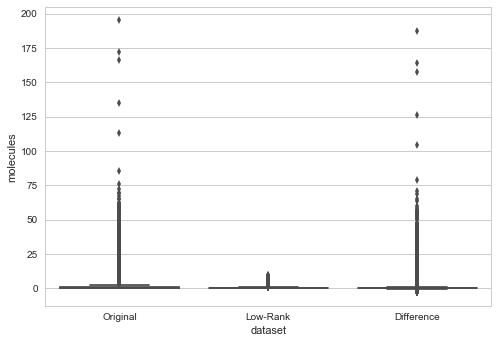

In [103]:
sns.boxplot(x='dataset', y='molecules', data=tidy)

In [37]:
S = pd.DataFrame(rpca_alm.S, index=table1.index, columns=table1.columns)
S.head()

,RHO,GNAT1,SLC24A1,PDE6B,PDC,CNGA1,RP1,SAG,NR2E3,NRL,...,SLC6A6,MAP1B,TMA7,STX3,SYT1,CRX,SNAP25,MPP4,NEUROD1,A930011O12RIK
barcode,,,,,,,,,,,,,,,,,,,,,
r1_TTCCTGCTAGGC,6.727705,-0.048168,-0.562439,0.801046,7.673487,-1.385031,-0.989380,0.458890,0.310256,0.654445,...,0.686886,0.232836,1.135861,-0.388544,-0.150222,-0.752207,-0.272070,0.167139,-1.258661,-0.856469
r1_TGGAGATACTCT,9.825846,2.519558,3.364314,0.286285,5.478891,6.689820,-1.257731,7.195869,-1.741139,-1.363235,...,2.184193,-1.031292,0.402444,-0.000000,-0.884529,-0.033574,-0.724387,0.763228,-2.351665,-0.286273
r1_CGTCTACATCCG,5.179712,0.214130,5.264080,-1.396476,0.828211,1.438757,-2.092837,5.163708,0.123617,0.462513,...,-0.382253,0.027997,-0.828423,2.343414,-0.391978,0.083947,-0.429003,1.041242,-1.373776,-0.703660
r1_CAAGCTTGGCGC,36.017770,6.978853,4.391547,12.048391,13.225699,-2.953723,0.572518,6.770184,2.922129,-2.769225,...,-1.644721,1.860076,3.728497,0.093386,-0.000000,3.248811,-0.020806,-0.190714,1.321210,7.187034
r1_ACTCACATAGAG,2.385108,-2.096781,-1.282597,-0.838656,0.868288,0.834004,-0.602792,0.337469,1.636147,-0.237918,...,0.312309,0.195454,0.920154,2.125570,0.315347,1.458115,0.245612,-0.499074,1.650005,-0.391946


In [21]:
diff.head()

,RHO,GNAT1,SLC24A1,PDE6B,PDC,CNGA1,RP1,SAG,NR2E3,NRL,...,SLC6A6,MAP1B,TMA7,STX3,SYT1,CRX,SNAP25,MPP4,NEUROD1,A930011O12RIK
barcode,,,,,,,,,,,,,,,,,,,,,
r1_TTCCTGCTAGGC,-6.727705,0.048168,0.562439,-0.801046,-7.673487,1.385031,0.989380,-0.458890,-0.310256,-0.654445,...,-0.686886,-0.232836,-1.135861,0.388544,0.150222,0.752207,0.272070,-0.167139,1.258661,0.856469
r1_TGGAGATACTCT,-9.825846,-2.519558,-3.364314,-0.286285,-5.478891,-6.689820,1.257731,-7.195869,1.741139,1.363235,...,-2.184193,1.031292,-0.402444,-0.000301,0.884529,0.033574,0.724387,-0.763228,2.351665,0.286273
r1_CGTCTACATCCG,-5.179712,-0.214130,-5.264080,1.396476,-0.828211,-1.438757,2.092837,-5.163708,-0.123617,-0.462513,...,0.382253,-0.027997,0.828423,-2.343414,0.391978,-0.083947,0.429003,-1.041242,1.373776,0.703660
r1_CAAGCTTGGCGC,-36.017770,-6.978853,-4.391547,-12.048391,-13.225699,2.953723,-0.572518,-6.770184,-2.922129,2.769225,...,1.644721,-1.860076,-3.728497,-0.093386,-0.000942,-3.248811,0.020806,0.190714,-1.321210,-7.187034
r1_ACTCACATAGAG,-2.385108,2.096781,1.282597,0.838656,-0.868288,-0.834004,0.602792,-0.337469,-1.636147,0.237918,...,-0.312309,-0.195454,-0.920154,-2.125570,-0.315347,-1.458115,-0.245612,0.499074,-1.650005,0.391946


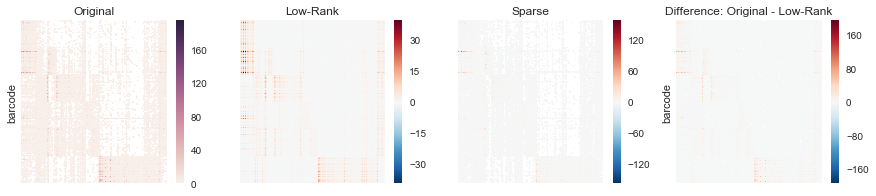

In [22]:
gr0 = rpca_alm.L > 0
diff_gr0 = table1 - gr0

datasets = {'Original': table1, 'Low-Rank':rpca_alm.L, 'Sparse': rpca_alm.S, 
            'Difference: Original - Low-Rank': diff_gr0}

common.heatmaps(datasets)

/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


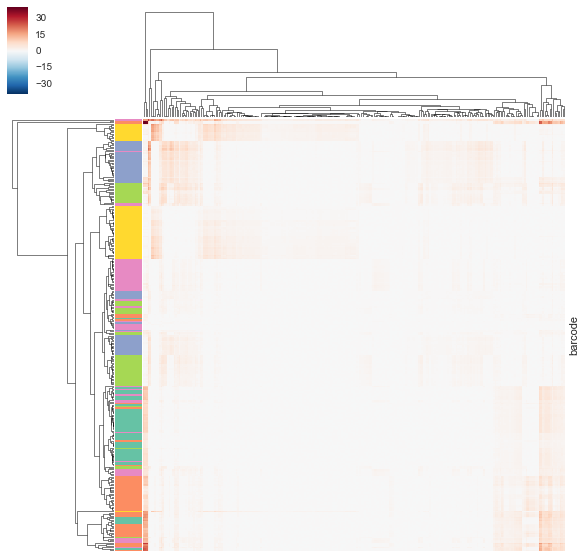

In [23]:
clustergrid = sns.clustermap(L, xticklabels=[], yticklabels=[], 
                             row_colors=color_labels)

/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


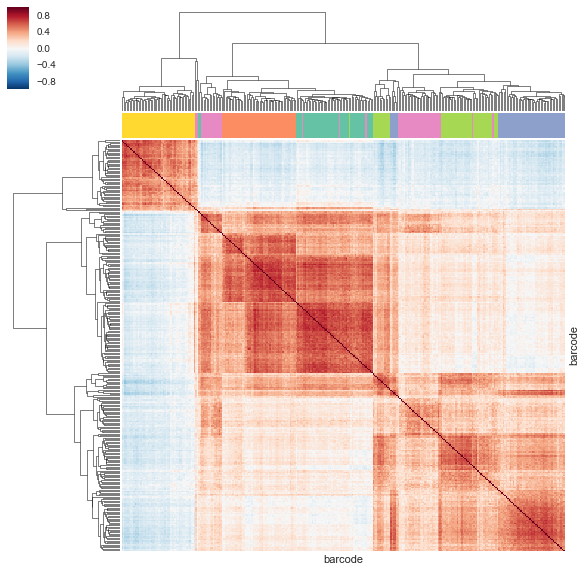

In [24]:
g_original = sns.clustermap(table1.T.corr(method='spearman'), xticklabels=[], yticklabels=[], 
                             col_colors=color_labels)

In [88]:
import fastcluster

In [89]:
fastcluster.pdist?

/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


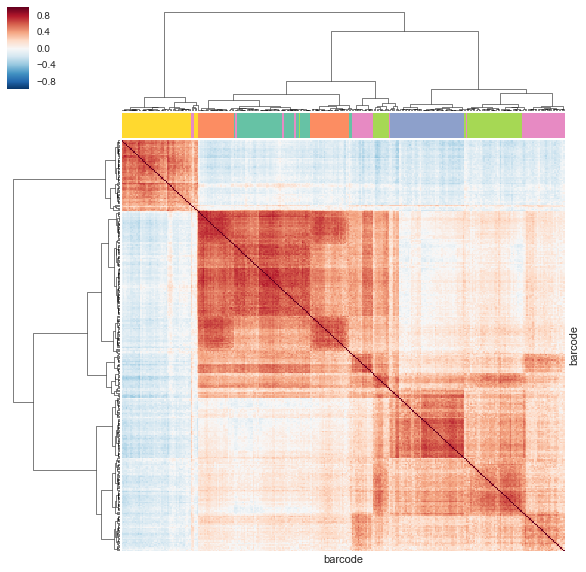

In [95]:
table1_clustergrid = common.clustermap(table1.T.corr(method='spearman'), col_colors=color_labels)
table1_clustergrid.savefig(os.path.join(figure_folder, 'expression_table1_clustermap.pdf'))

In [39]:
S.head()

,RHO,GNAT1,SLC24A1,PDE6B,PDC,CNGA1,RP1,SAG,NR2E3,NRL,...,SLC6A6,MAP1B,TMA7,STX3,SYT1,CRX,SNAP25,MPP4,NEUROD1,A930011O12RIK
barcode,,,,,,,,,,,,,,,,,,,,,
r1_TTCCTGCTAGGC,6.727705,-0.048168,-0.562439,0.801046,7.673487,-1.385031,-0.989380,0.458890,0.310256,0.654445,...,0.686886,0.232836,1.135861,-0.388544,-0.150222,-0.752207,-0.272070,0.167139,-1.258661,-0.856469
r1_TGGAGATACTCT,9.825846,2.519558,3.364314,0.286285,5.478891,6.689820,-1.257731,7.195869,-1.741139,-1.363235,...,2.184193,-1.031292,0.402444,-0.000000,-0.884529,-0.033574,-0.724387,0.763228,-2.351665,-0.286273
r1_CGTCTACATCCG,5.179712,0.214130,5.264080,-1.396476,0.828211,1.438757,-2.092837,5.163708,0.123617,0.462513,...,-0.382253,0.027997,-0.828423,2.343414,-0.391978,0.083947,-0.429003,1.041242,-1.373776,-0.703660
r1_CAAGCTTGGCGC,36.017770,6.978853,4.391547,12.048391,13.225699,-2.953723,0.572518,6.770184,2.922129,-2.769225,...,-1.644721,1.860076,3.728497,0.093386,-0.000000,3.248811,-0.020806,-0.190714,1.321210,7.187034
r1_ACTCACATAGAG,2.385108,-2.096781,-1.282597,-0.838656,0.868288,0.834004,-0.602792,0.337469,1.636147,-0.237918,...,0.312309,0.195454,0.920154,2.125570,0.315347,1.458115,0.245612,-0.499074,1.650005,-0.391946


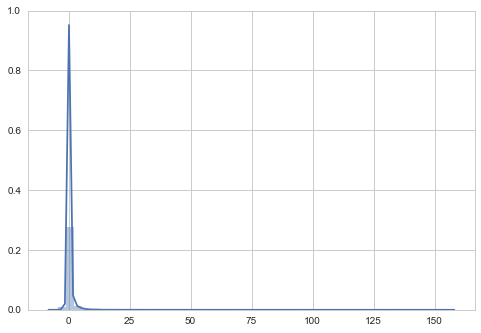

In [49]:
sns.distplot(S.values.flat)

In [52]:
np.median(S.values)

0.0

In [56]:
high_in_sparse = (S > 10).any()
print(high_in_sparse.sum())
S.loc[:, high_in_sparse]

88


,RHO,GNAT1,SLC24A1,PDE6B,PDC,CNGA1,RP1,SAG,NR2E3,NRL,...,TTYH1,PAX6,MGARP,HSP90AA1,SLC6A6,MAP1B,TMA7,SYT1,SNAP25,A930011O12RIK
barcode,,,,,,,,,,,,,,,,,,,,,
r1_TTCCTGCTAGGC,6.727705,-0.048168,-0.562439,0.801046,7.673487,-1.385031,-0.989380,0.458890,0.310256,0.654445,...,-0.000000,-0.000000,-0.302098,-0.081445,0.686886,0.232836,1.135861,-0.150222,-0.272070,-0.856469
r1_TGGAGATACTCT,9.825846,2.519558,3.364314,0.286285,5.478891,6.689820,-1.257731,7.195869,-1.741139,-1.363235,...,1.331571,0.998086,-1.093359,-1.256187,2.184193,-1.031292,0.402444,-0.884529,-0.724387,-0.286273
r1_CGTCTACATCCG,5.179712,0.214130,5.264080,-1.396476,0.828211,1.438757,-2.092837,5.163708,0.123617,0.462513,...,-0.341183,0.999751,1.902183,3.171176,-0.382253,0.027997,-0.828423,-0.391978,-0.429003,-0.703660
r1_CAAGCTTGGCGC,36.017770,6.978853,4.391547,12.048391,13.225699,-2.953723,0.572518,6.770184,2.922129,-2.769225,...,0.814278,0.000000,-1.179403,-0.254800,-1.644721,1.860076,3.728497,-0.000000,-0.020806,7.187034
r1_ACTCACATAGAG,2.385108,-2.096781,-1.282597,-0.838656,0.868288,0.834004,-0.602792,0.337469,1.636147,-0.237918,...,-0.082806,-0.000000,-0.509653,-0.000000,0.312309,0.195454,0.920154,0.315347,0.245612,-0.391946
r1_TAACGGACACGC,21.380107,1.663735,-0.021046,-0.222488,12.299926,4.287691,-0.672176,0.000000,-2.237709,9.267142,...,4.740199,0.000000,0.000000,-0.000000,0.952529,-1.441017,-0.406451,1.892411,-1.088772,0.354429
r1_CGCATGGGATAC,13.959024,3.970865,-1.348141,-0.892688,2.954439,-0.215551,1.402263,-0.000000,-0.442402,5.729592,...,2.569047,0.000000,-0.719147,1.672199,0.435023,1.349910,-0.755655,-0.504931,0.403079,-0.428073
r1_TAACGACGCTTG,3.180794,-0.447518,0.109158,-0.257555,-2.279500,0.203602,3.582963,2.171476,-0.986389,0.327993,...,-0.133089,-0.000000,-0.236654,0.158758,-0.000000,0.434394,-0.410368,-0.045431,0.000000,2.149970
r1_TCGGCAGCCTCT,0.000000,6.456903,-1.145033,1.899016,0.735434,1.092624,0.135634,9.117565,0.692410,2.080789,...,-0.266130,0.000000,0.000000,-0.887233,-0.409884,-1.027818,-0.134590,-0.516927,-0.389400,-1.188493


/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


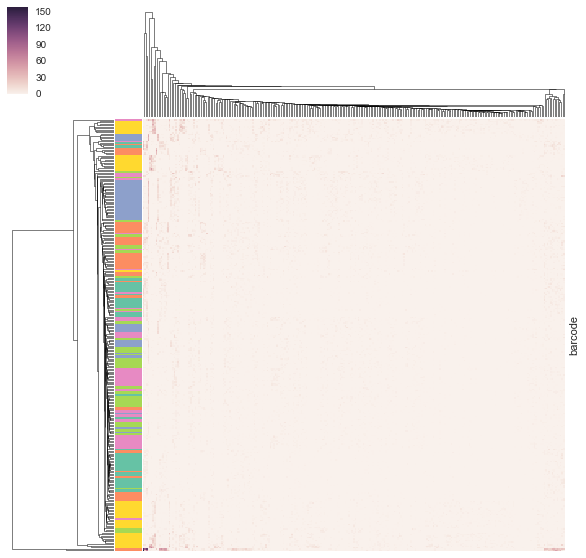

In [47]:

data = S[S > 0]
data = data.fillna(0)

g_rpca = sns.clustermap(data, xticklabels=[], yticklabels=[], row_colors=color_labels)


/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


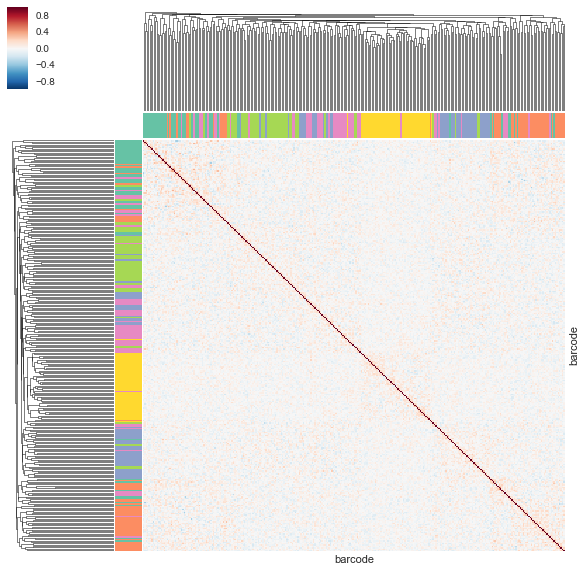

In [38]:

data = S.T.corr(method='spearman')
g_rpca = sns.clustermap(data, xticklabels=[], yticklabels=[],
                             col_colors=color_labels, row_colors=color_labels)


/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


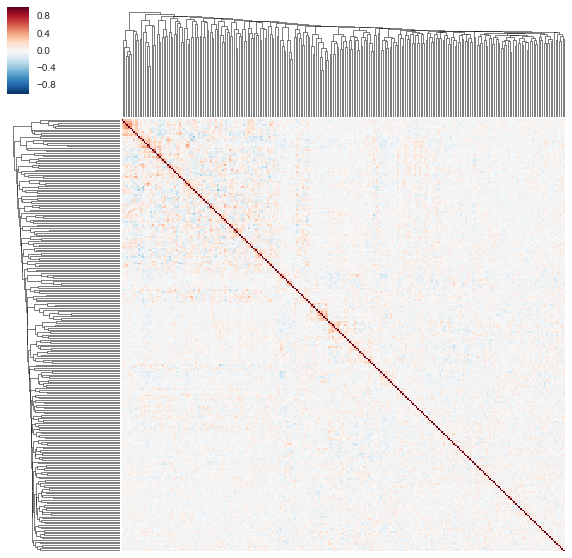

In [44]:

data = S.corr(method='spearman')
g_rpca = sns.clustermap(data, xticklabels=[], yticklabels=[])


/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


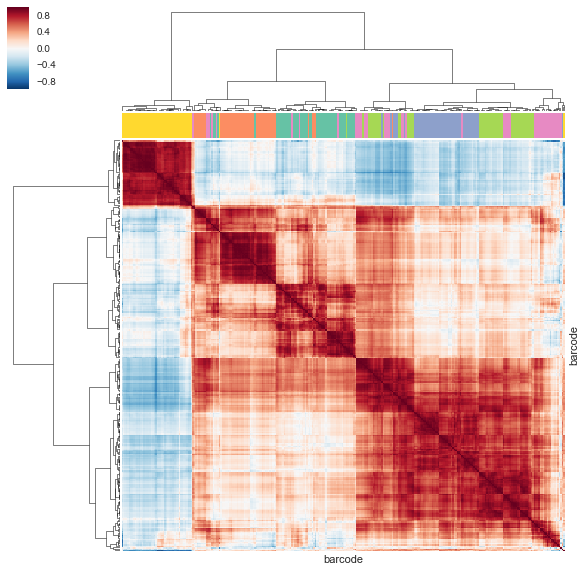

In [96]:

data = L.T.corr(method='spearman')
g_rpca = common.clustermap(data, col_colors=color_labels)
g_rpca.savefig(os.path.join(figure_folder, 'low_rank_clustermap.pdf'))

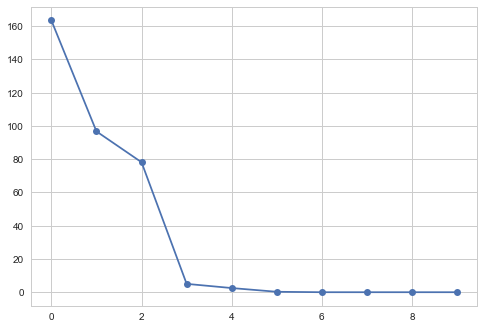

In [99]:
U, s, V = np.linalg.svd(L)
plt.plot(s[:10], 'o-')

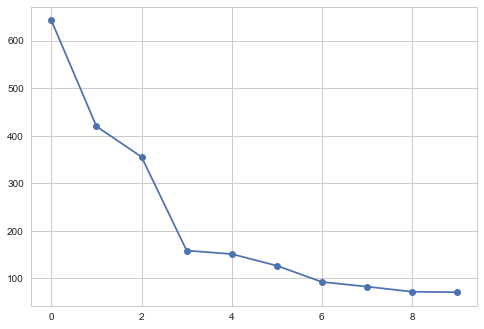

In [100]:
U, s, V = np.linalg.svd(table1)
plt.plot(s[:10], 'o-')

So this seemed to have flipped some of the cells into different types, and made the within-cluster distances smaller

/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


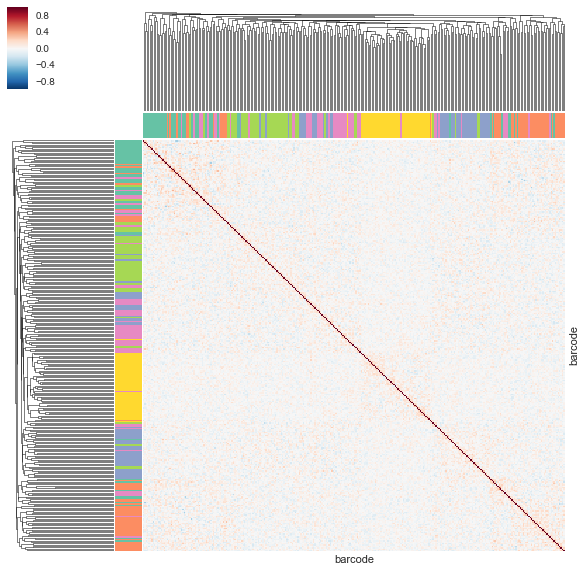

In [45]:
reconstructed = L + S

data = reconstructed.T.corr(method='spearman')
g_rpca = sns.clustermap(data, xticklabels=[], yticklabels=[],
                             col_colors=color_labels, row_colors=color_labels)


In [81]:
csv = os.path.join(data_folder, 'sparse.csv')

S.to_csv(csv)

In [83]:
data_folder

'data/002_robust_pca'

In [82]:
csv = os.path.join(data_folder, 'lowrank.csv')

L.to_csv(csv)

## Try ICA before and after

In [79]:
L.shape

(300, 259)

In [ ]:
from sklearn.decomposition import ICA

ica = ICA(n_components=)

## ADMM implementation

In [36]:
reduced = rpcaADMM.rpcaADMM(table1)
# print(reduced.shape)
# reduced.head()


iter	    r norm	   eps pri	    s norm	  eps dual	 objective
   1	  386.9989	    5.6518	  560.3478	    5.5259	  46003.39
  10	  126.6648	    7.4377	   57.8995	    7.7838	 274951.69
  20	   19.5261	    7.9579	   26.0279	    7.5066	 297640.42
  30	   10.9950	    8.0745	   10.9821	    7.3901	 300438.68


In [62]:
rpcaADMM.rpcaADMM()

In [38]:
reduced.keys()

dict_keys(['objval', 'r_norm', 's_norm', 'eps_pri', 'eps_dual', 'addm_toc', 'admm_iter', 'X1_admm', 'X2_admm', 'X3_admm'])

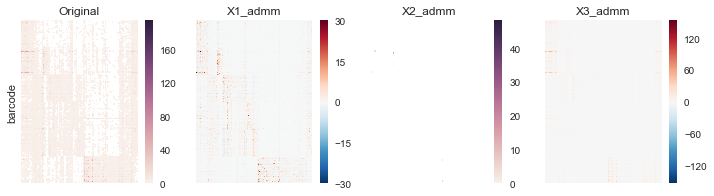

In [76]:
ncols = 4
nrows = 1

axsize = 3

width = ncols * axsize
height = nrows * axsize

fig, axes = plt.subplots(ncols=ncols, figsize=(width, height))
axes_iter = axes.flat

x_keys = [key for key in reduced if key.startswith('X')]

ax = next(axes_iter)
data = table1
mask = data == 0
sns.heatmap(table1, mask=mask, ax=ax, xticklabels=[], yticklabels=[])
ax.set(title='Original')

for ax, key in zip(axes_iter, x_keys):
    data = reduced[key]
    mask = data == 0
    
    vmin = data.min().min()
    vmax = data.max().max()
    center = 0
    sns.heatmap(reduced[key], mask=mask, ax=ax, xticklabels=[], yticklabels=[])
    ax.set(title=key)
    


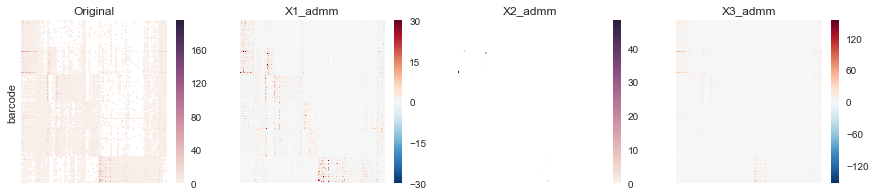

In [79]:
ncols = 4
nrows = 1

axsize = 3

width = ncols * axsize * 1.25
height = nrows * axsize

fig, axes = plt.subplots(ncols=ncols, figsize=(width, height))
axes_iter = axes.flat

x_keys = [key for key in reduced if key.startswith('X')]

ax = next(axes_iter)
common.heatmap(table1, ax=ax)
ax.set(title='Original')

for ax, key in zip(axes_iter, x_keys):
    common.heatmap(reduced[key], ax=ax)
    ax.set(title=key)
    


In [55]:
U, s, V = np.linalg.svd(reduced['X3_admm'])

In [61]:
reduced['X2_admm'][reduced['X2_admm'].nonzero()]

array([  0.06196856,   6.6911438 ,  13.40747184,   0.27285075,
        48.22056903,   2.24481196,   2.75026673,   0.05984601,   6.10384102])

In [80]:
ax

[autoreload of common failed: Traceback (most recent call last):
  File "/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/olgabot/anaconda3/envs/cshl-sca-2017/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 608, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._boot

In [81]:
sns.heatmap??